# Compile Slab2 model

Create a global NetCDF4 grid of the Slab2 model from [Hayes _et al._ 2018](https://doi.org/10.1126/science.aat4723). These data were accessed from [USGS](https://www.sciencebase.gov/catalog/item/5aa1b00ee4b0b1c392e86467) on the 29th of June 2022. 

#### References

Hayes, G. P., Moore, G. L., Portner, D. E., Hearne, M., Flamme, H., Furtney, M., & Smoczyk, G. M. (2018). Slab2, a comprehensive subduction zone geometry model. Science, 362(6410), 58–61. https://doi.org/10.1126/science.aat4723


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import netCDF4
import os
from scipy.interpolate import RegularGridInterpolator

In [5]:
def read_netcdf_grid(filename, return_grids=False, resample=None, realign=True):
    """Reads in a netCDF file and re-aligns its grid, lat and lon variables from -180 to 180 degrees.

    Can optionally resample grid if given required spacing in X and Y direction. Depending on user preference, it can 
    return the grid read from the file, or the grid along with its associated lat, lon arrays.
    
    Parameters
    ----------
    filename : str
        Path to netCDF file
        
    return_grids : bool, default=False
        If set to True, optionally returns lon, lat arrays associated with grid.
        
    resample : tuple, default=None
        Optionally resample grid, pass spacing in X and Y direction as a tuple
        e.g. resample=(spacingX, spacingY)

    Returns
    -------
    cdf_grid_z : array-like
        A numpy array of the grid defined by the supplied netCDF4 file. Can be resampled if given a specific spacing in 
        the X and Y directions. Entries are rescaled using longitudes between -180 and 180 degrees.

    cdf_lon, cdf_lat : array-like
        Numpy arrays encasing longitude and latitude variables belonging to the supplied netCDF4 file. Longitudes are 
        rescaled between -180 and 180 degrees.  
    """
    import netCDF4
    
    # open netCDF file and re-align from -180, 180 degrees
    with netCDF4.Dataset(filename, 'r') as cdf:
        cdf_grid = cdf["z"]
        try:
            cdf_lon = cdf['lon'][:]
            cdf_lat = cdf['lat'][:]
        except:
            cdf_lon = cdf['x'][:]
            cdf_lat = cdf['y'][:]
            
        cdf_lon_mask = cdf_lon[:] > 180
        
        if cdf_lon_mask.any() and realign:
            cdf_grid_z = np.hstack([cdf_grid[:,cdf_lon_mask], cdf_grid[:,~cdf_lon_mask]])
            cdf_lon = np.hstack([cdf_lon[cdf_lon_mask], cdf_lon[~cdf_lon_mask]])
        else:
            cdf_grid_z = cdf_grid[:]

    # resample
    if resample is not None:
        spacingX, spacingY = resample
        lon_grid = np.arange(cdf_lon.min(), cdf_lon.max()+spacingX, spacingX)
        lat_grid = np.arange(cdf_lat.min(), cdf_lat.max()+spacingY, spacingY)
        lonq, latq = np.meshgrid(lon_grid, lat_grid)
        interp = RegularGridInterpolator((cdf_lat, cdf_lon), cdf_grid_z, method='nearest', bounds_error=False)
        cdf_grid_z = interp((latq, lonq))
        cdf_lon = lon_grid
        cdf_lat = lat_grid
            
    if return_grids:
        return cdf_grid_z, cdf_lon, cdf_lat
    else:
        return cdf_grid_z
    
def write_netcdf_grid(filename, grid, extent=[-180,180,-90,90]):
    import netCDF4
    
    nrows, ncols = np.shape(grid)
    
    lon_grid = np.linspace(extent[0], extent[1], ncols)
    lat_grid = np.linspace(extent[2], extent[3], nrows)
    
    with netCDF4.Dataset(filename, 'w') as cdf:
        cdf.createDimension('x', lon_grid.size)
        cdf.createDimension('y', lat_grid.size)
        cdf_lon = cdf.createVariable('x', lon_grid.dtype, ('x',), zlib=True)
        cdf_lat = cdf.createVariable('y', lat_grid.dtype, ('y',), zlib=True)
        cdf_lon[:] = lon_grid
        cdf_lat[:] = lat_grid
        cdf_lon.units = "degrees"
        cdf_lat.units = "degrees"

        cdf_data = cdf.createVariable('z', grid.dtype, ('y','x'), zlib=True)
        cdf_data[:,:] = grid
        
def find_nearest_idx(array, value):
    return np.abs(array - value).argmin()

In [8]:
extent_globe = [-180,180,-90,90]

slab2_dir = "data/Slab2Distribute_Mar2018/"

dlon = 0.05
dlat = 0.05

# create world grid
lon_grid = np.arange(0, 360+dlon, dlon)
lat_grid = np.arange(-90, 90+dlat, dlat)
lonq, latq = np.meshgrid(lon_grid, lat_grid)


grid_dict = {'thk': np.full_like(lonq, np.nan, dtype=np.float32),
             'dep': np.full_like(lonq, np.nan, dtype=np.float32),
             'dip': np.full_like(lonq, np.nan, dtype=np.float32)}


for slab2_filename in os.listdir(slab2_dir):
    if slab2_filename.endswith('.grd'):
        
        key = slab2_filename[10:13]
        
        if key in grid_dict:
            grd, grd_lon, grd_lat = read_netcdf_grid(slab2_dir+slab2_filename,
                                                     return_grids=True,
                                                     resample=(dlon, dlat),
                                                     realign=False)

            j0 = find_nearest_idx(lon_grid, grd_lon.min())
            j1 = find_nearest_idx(lon_grid, grd_lon.max()) + 1
            i0 = find_nearest_idx(lat_grid, grd_lat.min())
            i1 = find_nearest_idx(lat_grid, grd_lat.max()) + 1

            grid_dict[key][i0:i1,j0:j1] = grd


# manipulate [0, 360] range to [-180, 180] range

lon_mask = lon_grid > 180

for key in grid_dict:
    grd = grid_dict[key]
    grd = np.hstack([grd[:,lon_mask], grd[:,~lon_mask]])
    grid_dict[key] = grd

lon_grid = np.hstack([lon_grid[lon_mask]-360-dlon, lon_grid[~lon_mask]])

In [9]:
# save netCDF4
for key in grid_dict:
    write_netcdf_grid('data/Slab2_compiled_{:s}.nc'.format(key), grid_dict[key], extent=extent_globe)

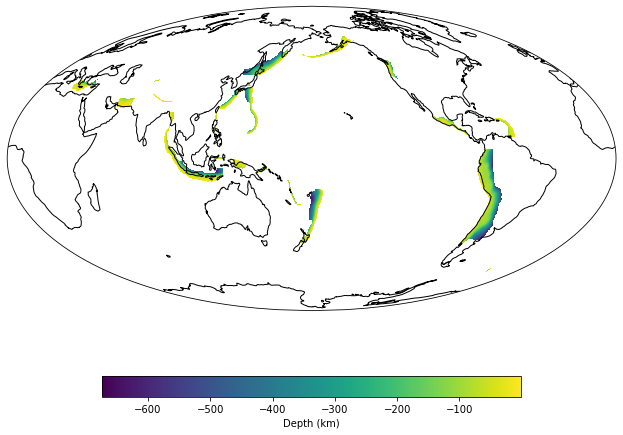

In [10]:
proj = ccrs.Mollweide(central_longitude=180)

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
ax.set_global()

im = ax.imshow(grid_dict['dep'], extent=extent_globe, origin='lower', transform=ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im, orientation='horizontal', shrink=0.5, label='Depth (km)')